# Trabalho 3: Avaliando sistemas de IR

Neste trabalho, o aluno irá explorar o problema de otimização de sistemas de IR através da análise de métricas de avaliação populares para esse tipo de sistema.

Para isso, vamos usar a base CFC (com artigos sobre fibrose cística), a qual encontra-se nesta pasta.

Observação: a idéia aqui é usar o jupyter para mostrar a evolução dos teus experimentos. Então use ele adequadamente. Ou seja, não altere funções do começo para reexecutar algo que foi feito lá embaixo. Neste caso, sobreescreva a função lá embaixo. A leitura do notebook tem que ser feita sequencialmente para ficar fácil, ok?


## Passo 1 - Normalização

Primeira coisa que você vai precisar fazer é ler os arquivos do CFC. Essa é uma parte meio braçal mesmo, mas não tem como escapar dela. Então você terá que criar funções que consigam ler cada arquivo do CFC e parsear eles.


In [1]:
import pandas as pd

# Imprime os dados no formato JSON
def printJson(data):
    print(json.dumps(data, indent=4))

# Função para ordenação - retorna attr number
def takeNumber(data):
    return data['number']

# Função para ordenação - retorna segundo elemento do array
def takeSecond(data):
    return data[1]

# Extrai artigos de um arquivo CFC
def extractCFCArticles(path):
    # Lista de campos do arquivo CFC
    fields = [
            'PN',
            'RN',
            'AN',
            'AU',
            'TI',
            'SO',
            'MJ',
            'MN',
            'AB',
            'EX',
            'RF',
            'CT',
    ]
    
    # Lista de campos que mudarao seus nomes
    cast = {
        'RN': 'record',
        'AB': 'content',
        'EX': 'content',
        'AN': 'an',
        'TI': 'title'
    }
    file = open(path).read()
    
    #Lista de artigos extraidos
    articles = []

    for article in file.split("\n\n"):
        # Objeto do artigo
        articleData = {
            'title':'',
            'record': 0,
            'year': 0,
            'number': 0,
            'an': 0,
            'AU': '',
            'SO': '',
            'MJ': [],
            'MN': [],
            'RF': [],
            'CT': [],
            'contentType': '',
            'content': '',
        }
        
        currentField = ''
        
        for line in article.split("\n"):
            # Linha vazia ou fim de arquivo
            if(not line.strip() or line.startswith("\x1a")):
                continue 
            
            for key in fields:
                # Verificase a linha é a definição de um novo atributo
                if(line.startswith(key + ' ')):
                    currentField = key
                    line = line[3:]
            
            line = line.strip()
            
            if(currentField == 'RF' or currentField == 'CT'):
                articleData[currentField].append(line)
                continue
                
            if(currentField == 'MJ' or currentField == 'MN'):
                articleData[currentField]+= line.split("  ")
                continue
            
            if(currentField == 'PN'):
                articleData['year'] = int(line[0:2])
                articleData['number'] = int(line[2])
                continue
            
            if(currentField == 'AB' or currentField == 'EX'):
                articleData['contentType'] = currentField
                
            if(currentField in cast):
                currentField = cast[currentField]
            
            if(currentField == 'record' or currentField == 'an'):
                articleData[currentField] = int(line)
                continue
                
                
            if(articleData[currentField]):
                articleData[currentField]+=' '
            articleData[currentField]+= line 
        
        if(articleData['title']):
            articles.append(articleData)
    return articles
 
#extraindo query 
def extractQueryFile(file):
    fields = [
        "QN",
        "QU",
        "NR",
        "RD"
    ]
    
    queriesList = open(file).read().split("\n")
    for i, line in enumerate(queriesList):
        queriesList[i] = line.strip()
    queriesList = "\n".join(queriesList).split("\n\n")
    
    queries = []
    for query in queriesList:
        query = query.strip()
        if not query: continue
        
        queryData = {
            'number':0,
            'text': '',
            'length': 0,
            'docs': [],
        }
        
        lines = query.split("\n")
        
        currentField = ''
        
        for line in query.split("\n"):
            for key in fields:
                # Verifica se a linha é a definição de um novo atributo
                if(line.startswith(key + ' ')):
                    currentField = key
                    line = line[3:]
                line = line.strip()

            if currentField == fields[0] or currentField == fields[2]:
                queryData['number' if currentField == fields[0] else 'length'] = int(line)
            elif currentField == fields[1]:
                if(queryData['text']):
                    queryData['text']+=' '
                queryData['text']+= line
            elif currentField == fields[3]:
                values = line.split(' ')
                doc = []
                for value in values:
                    if not value: continue
                    doc.append(value)
                    if len(doc) == 2:
                        doc[0] = int(doc[0])
                        weights = doc[1]
                        doc[1] = (int(weights[0]) + int(weights[1]) + int(weights[2]) + int(weights[3]))/4
                        queryData['docs'].append(doc)
                        doc = []
        queryData['docs'].sort(key=takeSecond,reverse=True)
        queries.append(queryData)
    queries.sort(key=takeNumber)
    return queries
                    
    
articles = [
    'data/cf74',
    'data/cf75',
    'data/cf76',
    'data/cf77',
    'data/cf78',
    'data/cf79'
]

queryFile = 'data/cfquery'

import json
data = extractCFCArticles(articles[5])

#Exibição dos 10 primeiros documentos
pd.DataFrame(extractQueryFile(queryFile)[0:10])


,docs,length,number,text
0,"[[533, 2.0], [139, 1.75], [441, 1.75], [151, 1...",34,1,What are the effects of calcium on the physica...
1,"[[875, 0.75], [434, 0.5], [592, 0.5], [169, 0....",7,2,Can one distinguish between the effects of muc...
2,"[[633, 2.0], [139, 1.75], [375, 1.75], [856, 1...",43,3,How are salivary glycoproteins from CF patient...
3,"[[604, 2.0], [876, 2.0], [711, 1.75], [669, 0....",9,4,What is the lipid composition of CF respirator...
4,"[[151, 2.0], [374, 2.0], [439, 2.0], [593, 2.0...",131,5,Is CF mucus abnormal?
5,"[[31, 2.0], [503, 1.25], [875, 1.0], [370, 0.5...",24,6,What is the effect of water or other therapeut...
6,"[[371, 1.75], [623, 1.5], [856, 1.25], [1064, ...",28,7,Are mucus glycoproteins degraded differently i...
7,"[[23, 1.5], [499, 1.5], [683, 1.5], [1125, 1.5...",22,8,What histochemical differences have been descr...
8,"[[414, 2.0], [165, 1.5], [794, 1.0], [1115, 0....",10,9,What is the association between liver disease ...
9,"[[157, 2.0], [413, 2.0], [581, 2.0], [676, 1.7...",25,10,What is the role of Vitamin E in the therapy o...


## Passo 2 - Primeira indexação

Depois de parsear os arquivos, agora é hora de indexar os dados. Ao invés de criar o código do zero, vamos usar o Whoosh, que é uma implementação em python inspirada no Lucene. A documentação pode ser encontrada em https://whoosh.readthedocs.io/en/latest/index.html.

Nesta questão de indexação, temos que fazer algumas escolhas: 
* Como fazer o processo de tokenização? 
* Stemmizar ou não stemmizar, eis a questão...
* Quais campos são úteis para indexação?

Neste momento, você vai tomar suas decisões iniciais. A ideia é você testar, depois, outras soluções para verificar quais tiveram os melhores resultados, entendeu? Então não esqueça de documentar, aqui, qual a sua decisão inicial e depois ir explicando ao longo do notebook os experimentos que está fazendo.

Para pesquisa e indexação, iremos avaliar principalmente os subjects. Estes, levantados por especialistas, contém informações sobre palavras-chave que definem os artigos. 

No geral, cada artigo possui um Major e Minor Subject. O primeiro define o foco do artigo enquanto o segundo, temas secundários abordados.

Dentro dos subjects, os termos são definidos seguindo o [vocabulário médico MeSH](https://meshb.nlm.nih.gov/), em alguns casos seguido de uma sigla de qualificadores (Ex di:diagnóstico).

A decisão inicial é usar destas informações para gerar indexação e ranqueamento de pesquisas. Priorizando o Major subject junto do qualificador, em seguida minor subjects

Usaremos também os autores e citações para calcular o H-index dos artigos

In [2]:
import os
from os import mkdir
from shutil import rmtree
from whoosh.index import create_in
from whoosh.fields import *

# (Re)Cria um banco com o nome e esquema informado
def createDB(db_name, schema):
    if os.path.exists(db_name):
        rmtree(db_name)
    os.mkdir(db_name)
    ix = create_in(db_name, schema)
    return ix


db_name = "indexdir"

#No Schema contém os campos que definimos como úteis para trabalahar neste trabalho
schema = Schema(title=TEXT(stored=True), 
                record=NUMERIC(stored=True), 
                year=NUMERIC(stored=True),
                number=NUMERIC(stored=True),
                an=NUMERIC(stored=True),
                content=TEXT,
                mn=TEXT,
                mj=TEXT,
               )

ix = createDB(db_name, schema)

def getDocCount(ix):
    searcher = ix.searcher()
    articlesLength = searcher.doc_count()
    searcher.close()    
    return articlesLength

def registerArticles(ix, articleFiles):
    writer = ix.writer()
    for file in articleFiles:
        for article in extractCFCArticles(file):
            mn = ""
            mj = ""
            for keyWord in article['MN']:
                mn+= ' ' + keyWord

            for keyWord in article['MJ']:
                mj+= ' ' + keyWord

            mn = mn.strip()
            mj = mj.strip()

            writer.add_document(title=article['title'],
                                record=article['record'],
                                year=article['year'],
                                number=article['number'],
                                an=article['an'],
                                content=article['content'],
                                mn=mn,
                                mj=mj
                               )

    writer.commit()
    return getDocCount(ix)
    

articlesLength = registerArticles(ix, articles)

print("OK")
print(articlesLength)


OK
1239


agora...

### Nesta etapa será evidenciado como foi criado a pesquisa  e análise dos resultados para cada query limitando a pesquisa a 100 consultas.

In [3]:
from whoosh.qparser import QueryParser
from whoosh.qparser import MultifieldParser
import whoosh

searcher = None

# Pesquisa inicial
def search(searchText, limit=100, ix=ix, textIndex=None, analizer=None):
    if(analizer):
        fixText = ""
        for word in analizer(searchText):
            fixText+=word.text + " "
        searchText = fixText.strip()
    textIndex = textIndex if textIndex else [
        "title", 
        "content", 
        "mn", 
        "mj"
    ]
    global searcher
    searcher = ix.searcher()
    og = whoosh.qparser.OrGroup.factory(0.9)
    parser = MultifieldParser(textIndex, schema=ix.schema, group=og)
    query = parser.parse(searchText)
    results = searcher.search(query, limit=limit)
    return results

def searchClose():
    global searcher
    searcher.close()
    
#Análise da busca
def getSearchAnalisis(queries, ix=ix, textIndex = None, analizer=None):
    analizedData = []
    for query in queries:
        data = search(query['text'], ix=ix, textIndex=textIndex, analizer=analizer)
        results = data
        printData = {
            'QueryNumber': query['number'],
            'totalEsperado': query['length'],
            'totalEncontrado': len(results),
            'totalRetornado': results.scored_length(),
            'docs': [],
        }

        for i, result in enumerate(query['docs']):
            printData['docs'].append([
                query['docs'][i][0],
                query['docs'][i][1],
                0 if results.scored_length() <= i else results[i]['record']
            ])
        analizedData.append(printData)
        searchClose()
    return analizedData

prints = getSearchAnalisis(extractQueryFile(queryFile))

pd.DataFrame(prints[0:10])


,QueryNumber,docs,totalEncontrado,totalEsperado,totalRetornado
0,1,"[[533, 2.0, 533], [139, 1.75, 975], [441, 1.75...",541,34,100
1,2,"[[875, 0.75, 754], [434, 0.5, 592], [592, 0.5,...",718,7,100
2,3,"[[633, 2.0, 633], [139, 1.75, 856], [375, 1.75...",1010,43,100
3,4,"[[604, 2.0, 725], [876, 2.0, 148], [711, 1.75,...",556,9,100
4,5,"[[151, 2.0, 975], [374, 2.0, 151], [439, 2.0, ...",409,131,100
5,6,"[[31, 2.0, 31], [503, 1.25, 47], [875, 1.0, 59...",736,24,100
6,7,"[[371, 1.75, 856], [623, 1.5, 439], [856, 1.25...",1009,28,100
7,8,"[[23, 1.5, 124], [499, 1.5, 11], [683, 1.5, 17...",947,22,100
8,9,"[[414, 2.0, 545], [165, 1.5, 296], [794, 1.0, ...",735,10,100
9,10,"[[157, 2.0, 1218], [413, 2.0, 676], [581, 2.0,...",840,25,100


## Passo 3 - Calculando as métricas de avaliação

Para avaliar a tua decisão, vamos usar como métricas a precisão, recall e f-measure. Faça uma variação da precisão e recall como P@n e R@n, pois serão úteis para os gráficos que serão gerados. 

In [4]:

def safeDivide(a, b):
    return 0 if not b else a/b

def listSlice(valuesList, n=None):
    n = n if n else len(valuesList)
    return valuesList[:n]


#Extração dos IDs da busca
def extractSearchIds(results):
    ids = []
    for doc in results:
        ids.append(doc['record'])
    return ids


#Extração dos IDs das querys
def extractQueryIds(query):
    ids = []
    for doc in query['docs']:
        ids.append(doc[0])
    return ids

#Cálculo dos verdadeiros positivos
def getTruePositives(searchIds, queryIds):
    return len(set(searchIds) & set(queryIds))

#Cálculo dos falsos positivos 
def getFalsePositives(searchIds, queryIds):
    return len(searchIds) - getTruePositives(searchIds, queryIds)
#Cálculo dos falsos negativos
def getFalseNegatives(searchIds, queryIds):
    return len(queryIds) - getTruePositives(searchIds, queryIds)

#Cálculo dos verdadeiros negativos
def getTrueNegatives(searchIds, queryIds, articlesLength=articlesLength):
    return articlesLength + getTruePositives(searchIds, queryIds) - getFalseNegatives(searchIds, queryIds) - getFalsePositives(searchIds, queryIds)


#Cálculo da Presição
def getPrecision(searchIds, queryIds, n=None):
    searchIds = listSlice(searchIds, n)
    return safeDivide(getTruePositives(searchIds, queryIds), 
                      getTruePositives(searchIds, queryIds) + getFalsePositives(searchIds, queryIds)
                     )
#Cálculo do Recall
def getRecall(searchIds, queryIds, n=None):
    searchIds = listSlice(searchIds, n)
    return safeDivide(getTruePositives(searchIds, queryIds) ,
                      getTruePositives(searchIds, queryIds) + getFalseNegatives(searchIds, queryIds)
    )

#Cálculo f-measure
def getFMeasures(searchIds, queryIds):
    return safeDivide(2 * getRecall(searchIds, queryIds) * getPrecision(searchIds, queryIds) ,
                      getPrecision(searchIds, queryIds) +  getRecall(searchIds, queryIds) 
                     )

def getSearchMetrics(queryFile, ix=ix, queriesLimit=100, textIndex=None, analizer=None ):
    metrics = []
    doneQueries = []
    for query in extractQueryFile(queryFile):
        results = search(query['text'],limit=queriesLimit, ix=ix, textIndex=textIndex, analizer=analizer)

        searchIds = extractSearchIds(results)
        queryIds = extractQueryIds(query)

        doneQueries.append([searchIds, queryIds])


        metricsData = {
            'len': query['length'],
            'trueP': getTruePositives(searchIds, queryIds),
            'trueN': getTrueNegatives(searchIds, queryIds, getDocCount(ix)),
            'falseP':getFalsePositives(searchIds, queryIds),
            'falseN':getFalseNegatives(searchIds, queryIds),
            'precision':getPrecision(searchIds, queryIds),
            'recall':getRecall(searchIds, queryIds),
            'f-measure':getFMeasures(searchIds, queryIds),
            'p@1':getPrecision(searchIds, queryIds, n=1),
            'r@1':getRecall(searchIds, queryIds, n=1),
            'p@5':getPrecision(searchIds, queryIds, n=5),
            'r@5':getRecall(searchIds, queryIds, n=5),
            'p@10':getPrecision(searchIds, queryIds, n=5),
            'r@10':getRecall(searchIds, queryIds, n=5),
        }

        metrics.append(metricsData)
        searchClose()
    return metrics, doneQueries


queriesLimit = 100
prints, doneQueries = getSearchMetrics(queryFile, ix, queriesLimit)

print("Results: ")
pd.DataFrame(prints)

Results: 


,f-measure,falseN,falseP,len,p@1,p@10,p@5,precision,r@1,r@10,r@5,recall,trueN,trueP
0,0.313433,13,79,34,1.0,0.2,0.2,0.21,0.029412,0.029412,0.029412,0.617647,1168,21
1,0.056075,4,97,7,0.0,0.2,0.2,0.03,0.000000,0.142857,0.142857,0.428571,1141,3
2,0.209790,28,85,43,1.0,0.8,0.8,0.15,0.023256,0.093023,0.093023,0.348837,1141,15
3,0.110092,3,94,9,0.0,0.0,0.0,0.06,0.000000,0.000000,0.000000,0.666667,1148,6
4,0.337662,92,61,131,1.0,1.0,1.0,0.39,0.007634,0.038168,0.038168,0.297710,1125,39
5,0.209677,11,87,24,1.0,0.6,0.6,0.13,0.041667,0.125000,0.125000,0.541667,1154,13
6,0.078125,23,95,28,1.0,0.8,0.8,0.05,0.035714,0.142857,0.142857,0.178571,1126,5
7,0.065574,18,96,22,0.0,0.2,0.2,0.04,0.000000,0.045455,0.045455,0.181818,1129,4
8,0.145455,2,92,10,0.0,0.2,0.2,0.08,0.000000,0.100000,0.100000,0.800000,1153,8
9,0.176000,14,89,25,1.0,0.8,0.8,0.11,0.040000,0.160000,0.160000,0.440000,1147,11


## Passo 4 - Gráficos do experimento 1

Apresentar agora os gráficos do teu experimento. Você deve gerar um gráfico PxR, como visto em sala. Para gerar gráficos, você pode usar o matplotlib. Se quiser usar outra biblioteca que ache mais fácil, sem problemas!

In [5]:
import matplotlib.pyplot as plt

def generateChartVariation(queryValuesList, limit=100, legend=None):
    charts = []
    for queryValues in queryValuesList:
        pontosX = []
        pontosY = []

        for i in range(limit):
            n = i+1
            pMedia = 0
            rMedia = 0
            for data in queryValues:
                pMedia+= getPrecision(data[0], data[1], n)
                rMedia+= getRecall(data[0], data[1], n)
            pontosX.append(pMedia/limit)
            pontosY.append(rMedia/limit)
        charts.append([pontosX, pontosY])

    if not legend:
        legend = []
        for i in range(1, len(queryValuesList)+1):
            legend.append("Valor "+ str(i))
    plt.title("gráfico PxR")
    for chart in charts:
        plt.plot(chart[0], chart[1])
    plt.legend(legend)
    plt.show()

    plt.title("gráfico NxP")
    for chart in charts:
        plt.plot(range(1, limit+1), chart[0])
    plt.legend(legend)
    plt.show()

    plt.title("gráfico NxR")
    for chart in charts:
        plt.plot(range(1, limit+1), chart[1])
    plt.legend(legend)
    plt.show()

# printJson(doneQueries)
generateChartVariation([doneQueries], limit=queriesLimit, legend=["Query Padrão"])

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

1° Gráfico e representa a precisão(P) pelo Recall(R).

2° Gráfico representa o números de elementos retornado pelo precisão(P).

3° Gráfico representa o números de elementos retornado pelo recall(R).

O limite padrão das queries é 100.


## Passo 5 - Demais experimentos

Agora você irá testar novas configurações de campos e configurações para tentar encontrar qual a que te dá melhores resultados. Mostrar, como um relatório, a evolução do trabalho. Ou seja, mostrar como o trabalho foi evoluindo para você alcançar o melhor resultado (quais modificações foram feitas, como cada modificação influenciou nas métricas, etc).

###  Com intuito de melhorar os resultados obitidos até o presente momento, foi utilzado a stemização do whoosh tendo como parametro uma lista de stopWords. A lista de stopWords é uma das N listas disponível no google para a linguagem EN.   

#### Foi implementado 2 análise diferentes para comparar qual método poderia ser considerado como um bom resultado para a base processada.

#### Para não ocorrer o risco de sobrescrever o banco criado anteriormente, foi criado um novo banco para as novas análises.




In [6]:
from whoosh.analysis import (StemmingAnalyzer,
                             RegexTokenizer, NgramTokenizer, StandardAnalyzer)

stopWords = ["i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself","yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their","theirs","themselves","what","which","who","whom","this","that","these","those","am","is","are","was","were","be","been","being","have","has","had","having","do","does","did","doing","a","an","the","and","but","if","or","because","as","until","while","of","at","by","for","with","about","against","between","into","through","during","before","after","above","below","to","from","up","down","in","out","on","off","over","under","again","further","then","once","here","there","when","where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor","not","only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"]
analizer = StemmingAnalyzer(stoplist=stopWords) 

schemaStemmer = Schema(title=TEXT(stored=True, analyzer=analizer), 
                record=NUMERIC(stored=True), 
                year=NUMERIC(stored=True),
                number=NUMERIC(stored=True),
                an=NUMERIC(stored=True),
                content=TEXT(analyzer=analizer),
                mn=KEYWORD(analyzer=analizer, scorable=True),
                mj=KEYWORD(analyzer=analizer, scorable=True),
               )

db2_name = "indexdir2"

ixStem = createDB(db2_name,schemaStemmer)

print("Banco 2 criado")

ixRegistered = registerArticles(ixStem, articles)
print("Artigos registrados")

Banco 2 criado
Artigos registrados


### Geração de gráficos 

Os gráficos mostrados abaixo a linha em cor azul representa a primeira etapa do trabalho, a linha em cor laranja presenta o resultado das modificações  da etapa 2.



Pesquisa 1 concluida
Pesquisa 2 concluida


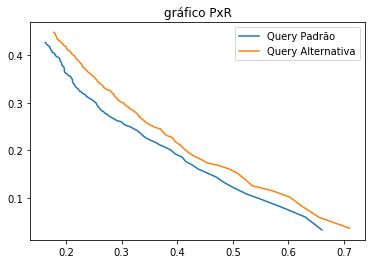

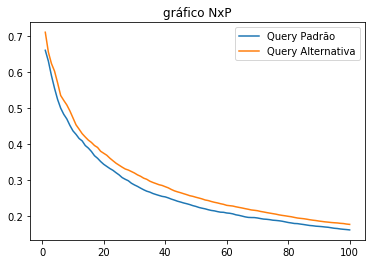

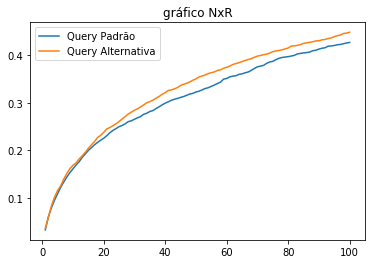

In [7]:
metrics, data = getSearchMetrics(queryFile, ix=ixStem, analizer=analizer, textIndex=[
    "title", 
    "content", 
    "mn", 
    "mj"])
print("Pesquisa 1 concluida")

metrics2, data2 = getSearchMetrics(queryFile, ix=ix)
print("Pesquisa 2 concluida")

generateChartVariation([data2, data],  legend=["Query Padrão", "Query Alternativa", "Q Analyzer"])

1° Gráfico e representa a precisão(P) pelo Recall(R).

2° Gráfico representa o números de elementos retornado pelo precisão(P).

3° Gráfico representa o números de elementos retornado pelo recall(R).

O limite padrão das queries é 100.


O que ser observado nos gráficos que o método adotado para analisar apresentou uma leve melhora nos resultados obtidos.


### Abaixo foi desenvolvido uma 2° análise com criação de um  banco para armazenar os novos resultados
  
    

In [8]:
from whoosh.analysis import (RegexTokenizer, StandardAnalyzer, LowercaseFilter, StopFilter)

regexAnalizer = RegexTokenizer() |  LowercaseFilter() | StopFilter(minsize=4, stoplist=stopWords)

schemaRegex = Schema(title=TEXT(stored=True, analyzer=regexAnalizer), 
                record=NUMERIC(stored=True), 
                year=NUMERIC(stored=True),
                number=NUMERIC(stored=True),
                an=NUMERIC(stored=True),
                content=TEXT(analyzer=regexAnalizer),
                mn=KEYWORD(analyzer=regexAnalizer, scorable=True),
                mj=KEYWORD(analyzer=regexAnalizer, scorable=True),
               )

db3_name = "indexdir3"

ixRegex = createDB(db3_name,schemaRegex)

print("Banco 3 criado")

registerArticles(ixRegex, articles)
print("Artigos registrados")

Banco 3 criado
Artigos registrados


Pesquisa 3 concluida


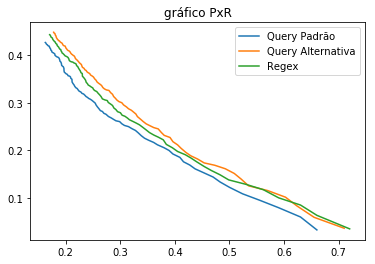

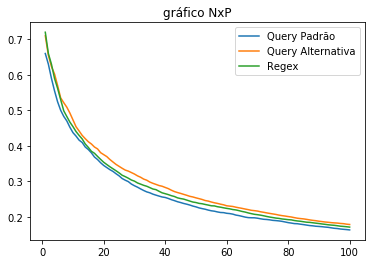

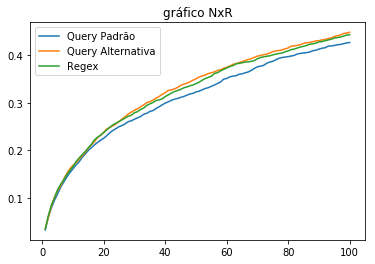

In [9]:
metrics3, data3 = getSearchMetrics(queryFile, ix=ixRegex, analizer=regexAnalizer, textIndex=[
    "title", 
    "content", 
    "mn", 
    "mj"])
print("Pesquisa 3 concluida")

generateChartVariation([data2, data, data3],  legend=["Query Padrão", "Query Alternativa", "Regex"])

1° Gráfico e representa a precisão(P) pelo Recall(R).

2° Gráfico representa o números de elementos retornado pelo precisão(P).

3° Gráfico representa o números de elementos retornado pelo recall(R).

O limite padrão das queries é 100.


O que ser observado nos gráficos é que os métodos adotados para analise apresentou uma leve melhora nos resultados obtidos. Mas o melhor resultado e relativo, pois depende de qual objetivo o dono da base deseja. No  nosso caso desejamos melhorar a precisão e o recall com objetivo fim.

### Passo 6 - Quantos resultados eu devo voltar para o usuário?

Um dos problemas de sistemas de IR é determinar quantos resultados você deve retornar ao usuário. Uma forma de entender o comportamento do sistema e qual o corte ideal na lista resultante é através do uso de curvas ROC. Assim, plote a curva ROC do teu sistema e determine, através da análise da curva, qual o ponto ideal de corte para o teu sistema.

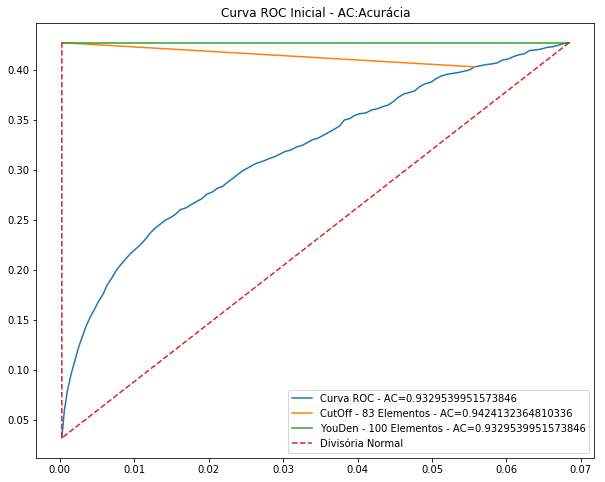

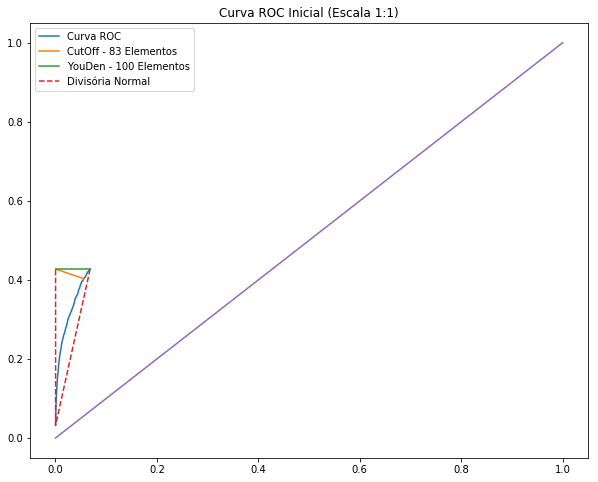

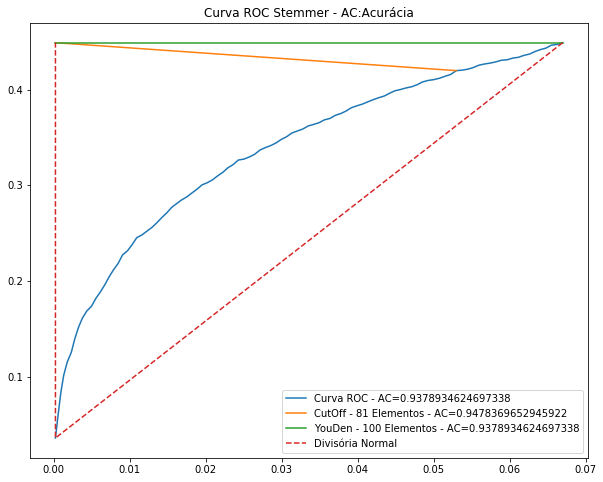

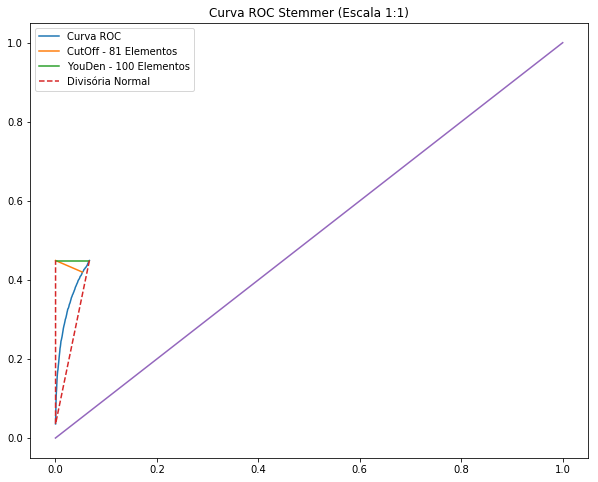

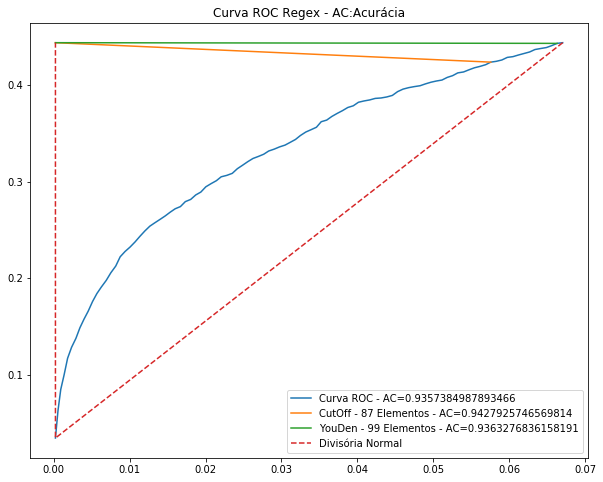

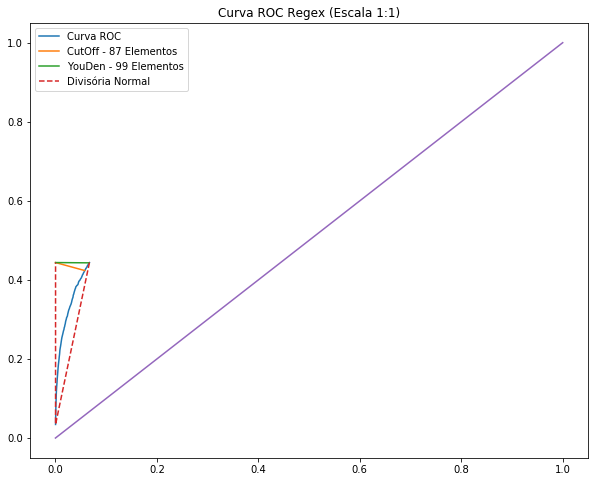

In [155]:
from math import sqrt

plt.rcParams["figure.figsize"] = (10,8)


def getTotalPositives(searchIds, queryIds):
    return getTruePositives(searchIds, queryIds) + getFalseNegatives(searchIds, queryIds)

def getTotalNegatives(searchIds, queryIds, docCount):
    return getTrueNegatives(searchIds, queryIds,docCount) + getFalsePositives(searchIds, queryIds)

# Calcula a taxa de True Positives
def getTPRate(searchIds, queryIds, n=None):
    searchIds = listSlice(searchIds, n)
    return getTruePositives(searchIds, queryIds) / getTotalPositives(searchIds, queryIds)

# Calcula a taxa de False Positives 
def getFPRate(searchIds, queryIds, docCount, n=None):
    searchIds = listSlice(searchIds, n)
    return getFalsePositives(searchIds, queryIds) / getTotalNegatives(searchIds, queryIds, docCount)

# Calcula Sensibilidade
def getSensibility(searchIds, queryIds, n=None):
    return getTPRate(searchIds, queryIds, n)

# Calcula Specificidade
def getSpecificity(searchIds, queryIds, docCount, n=None):
    return 1 - getFPRate(searchIds, queryIds, docCount, n)

def getHigherValue(valuesList):
    value = valuesList[0]
    index = 0
    for i, newValue in enumerate(valuesList):
        if newValue > value:
            value = newValue
            index = i
    return index

def getLowerValue(valuesList):
    value = valuesList[0]
    index = 0
    for i, newValue in enumerate(valuesList):
        if newValue < value:
            value = newValue
            index = i
    return index

def getPointsDistance(pointA, pointB):
    return sqrt( ((pointB[0]*1000) - (pointA[0]*1000))**2 + ((pointB[1]*1000) - (pointA[1]*1000))**2 )



def getRocCurve(queryValues, docCount, limit=100):
    x = []
    y = []
    cutoff = []
    youden = []
    
    for i in range(1, limit+1):
        cutoffMedia = 0
        youdenMedia = 0
        count = 0
        
        sensMedia = 0
        specMedia = 0
        
        for query in queryValues:
            count+=1
            sensitivity = getSensibility(query[0], query[1], n=i)
            specificity = getSpecificity(query[0], query[1], docCount, n=i)
            
            sensMedia+=sensitivity
            specMedia+=specificity
         
        sensMedia = sensMedia / count
        specMedia = specMedia / count            
        
        x.append( 1 - specMedia)
        y.append( sensMedia)
        
        
    for i, xPoint in enumerate(x):
#         xPoint = x[i]
        yPoint = y[i]
        cutoff.append(getPointsDistance([xPoint, yPoint], [x[0], y[-1]]))
        youden.append(yPoint + (1 - xPoint) - 1)
#     printJson([begin, end])
    
        
    return x, y, cutoff, youden

def getAccuracy(searchIds, queryIds, docCount, n=None):
    searchIds = listSlice(searchIds, n)
    return safeDivide(getTruePositives(searchIds, queryIds) + getTrueNegatives(searchIds, queryIds, docCount),
                     docCount)

def getAccuracyMedia(queryValues, docCount, limit=100):
    
    count = 0
    accuracy = 0
    for query in queryValues:
        count+=1
        accuracy+=getAccuracy(query[0], query[1], docCount, limit)
    return accuracy / count


def generateRocGraph(data, ix, title="Curva ROC"):
    x, y, cutoff, youden = getRocCurve(data, getDocCount(ix))
    top = [x[0], y[-1]]
    
    


    plt.title(title + " - AC:Acurácia")

    # Curva ROC
    plt.plot(x, y)

    # Melhor ponto por CutOff
    plt.plot(
        [top[0], x[getLowerValue(cutoff)]],
        [top[1],y[getLowerValue(cutoff)]]
    )
    
     # Melhor ponto por YouDen
    plt.plot(
        [top[0], x[getHigherValue(youden)]],
        [top[1],y[getHigherValue(youden)]]
    )
    
    # Divisória e normal
    plt.plot(
        [x[-1],x[0],top[0]], 
        [y[-1],y[0],top[1]],
        linestyle='--'
    )
    
    plt.legend([
        "Curva ROC - AC=" + str(getAccuracyMedia(data, getDocCount(ix))), 
        "CutOff - "+str(getLowerValue(cutoff)+1) + " Elementos - AC=" + str(getAccuracyMedia(data, getDocCount(ix), limit=getLowerValue(cutoff)+1)),
        "YouDen - " + str(getHigherValue(youden) + 1) + " Elementos - AC=" + str(getAccuracyMedia(data, getDocCount(ix), limit=getHigherValue(youden)+1)),
        "Divisória Normal"
    ])
    plt.show()
    
    # Gráfico com escala 1:1
    plt.title(title + " (Escala 1:1)")
    plt.plot(x, y)
    plt.plot(
        [top[0], x[getLowerValue(cutoff)]],
        [top[1],y[getLowerValue(cutoff)]]
    )
    plt.plot(
        [top[0], x[getHigherValue(youden)]],
        [top[1],y[getHigherValue(youden)]]
    )
    plt.plot(
        [x[-1],x[0],top[0]], 
        [y[-1],y[0],top[1]],
        linestyle='--'
    )
    plt.plot([0,1], [0,1])
    plt.legend([
        "Curva ROC", 
        "CutOff - "+str(getLowerValue(cutoff)+1) + " Elementos",
        "YouDen - " + str(getHigherValue(youden) + 1) + " Elementos",
        "Divisória Normal"
    ])    
    plt.show()
    

generateRocGraph(data2, ix, "Curva ROC Inicial")
generateRocGraph(data, ixStem, "Curva ROC Stemmer")
generateRocGraph(data3, ixRegex, "Curva ROC Regex")

###  Sobre os gráficos

Os gráficos são mostrados em pares onde o primeiro não está em escala real e mostra mais informações, enquanto o segundo detalha os dados em escala real.

#### Indexações

A indexação que teve maior acurácia no geral foi a de stemmização, em um valor de aproximadamente 0.9478 aplicando cutOff. 

A indexação por Regex obteve melhores resultados do que a indexação inicial porém ao analizar a por stemmização atingiu resultados melhores.

#### Dados dos gráficos

Após a execução do algorítmo para CutOff, foi detectado o valor de 83 elementos como menor distância de specificidade e sensibilidade, levando a uma maior acurácia.

O Algorítimo de YouDen não foi efetivo com esta coleção, pois apenas detectou melhoria na indexação por Regex.